<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/3_First_order_methods/B_10_Automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix B. Derivatives and Automatic Differentiation

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# B.10 Using the autograd / JAX Library

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_3_library').is_dir():
        !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/3_First_order_methods/chapter_3_library
    else:
        print('chapter_3_library already cloned!')

    # clone images
    if not Path('chapter_3_images').is_dir():
        !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/3_First_order_methods/chapter_3_images
    else:
        print('chapter_3_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_3_library')
sys.path.append('./chapter_3_images') 

# import section helper
import section_3_5_helpers

# image paths
image_path_1 = 'chapter_3_images/flattening.png'

# standard imports
from IPython.display import Image, HTML

%load_ext autoreload
%autoreload 2

Think about how you perform basic arithemetic - say how you perform the multiplication of two numbers.  If the two numbers are small - say $8$ times $7$, or $5$ times $2$ - you can likely do the multiplication in your head.  This is because in school you likely learned a variety of tricks for multiplying two small numbers together - say up to two or three digits each - as well as *algorithms* for multiplying two arbitrary numbers by hand.  Both the tricks and the algorithm are valuable tools to have when computing e.g., interest on a loan or investment, making quick back of the envelope calculations, etc.,  But even though the algorithm for multiplication is *simple*, *repetitive*, and works regardless of the two numbers you multiply together you would likely never compute the product of two arbitrarily large numbers yourself - like $140,283,197,523 \times 224,179,234,112$.  Why?   Because while the algorithm for multiplication is simple and repetitive, it is *time consuming* and *boring* for you to enact yourself.  Instead you would likely use a *calculator* to multiply two arbitrarily large numbers together because it *automates the process of using the multiplication algorithm*.  An arithmetic calculator allows *you* to compute with much greater efficiency and accuracy, and empowers you to use the fruits of arithmetic computation for more important tasks.  

This is precisely how you can think about the computation of derivatives / gradients.  Perhaps you can compute the derivative of simple mathematical functions in your head - like e.g., $g(w) = w^3$ and $g(w) = \text{sin}(w)$.  This is because in school you likely learned a variety of tricks for computing the derivative of simple functions - like sums of elementary polynomials or sinusoids - as well as *algorithms* for computing the derivative or gradient of arbitrarily complicated functions (if not you can find a refresher on these subjects in the text's Appendix).  These skills are useful - as some level of familiarity with them is requisite in order for one to grasp basic concepts in optimization as well as the examples used to flush them out.  But even though the algorithm for gradient computation is *simple*, *repetitive*, and works regardless of mathematical function you wish to differentiate you would likely never compute the gradient of an arbitrarily complicated function yourself - like $g\left(w_1,w_2\right) = 2^{\text{sin}\left(0.1w_1^2 + 0.5w_2^2\right)}\text{tanh}\left(\text{cos}\left(0.2w_1w_2\right)\right)\text{tanh}\left(w_11w_2^4\text{tanh}\left(w_1 + {\text{sin}\left(0.2w_2^2\right)} \right) \right)$.  Why?   Because while the algorithm for computing derivatives is simple and repetitive, it is *time consuming* and *boring* for you to enact yourself.  Instead you would likely use a *calculator* to compute the derivatives of an arbitrary complicated mathematical functions because it *automates the process of using the differentiation algorithm*.  A gradient calculator allows *you* to compute with much greater effeciency and accuracy, and empowers you to use the fruits of gradient computation for more important tasks - e.g., for the popular first order *local optimization* schemes that are widely used in machine learning.

Gradient calculators are more commonly called *Automatic Differentiators*.  In this Section we demonstrate how to use a simple yet powerful *Automatic Differentiator* written in `Python` called `autograd`, a tool we will make extensive use of throughout the text.  Interested users can also see this text's electronic resources for an analagous walkthrough of the `PyTorch` version of `autograd` as well.  In later Chapters and the appendix of this text we will dive deeply into more technical details about how Automatic Differentiators work, but for now we simply need to know *how to use one* - which is what this Section is all about. 

## Installing `autograd`

[Autorad](https://github.com/HIPS/autograd) is an open source professional grade gradient calculator, or *Automatic Differentiator*.  Built with simplicity in mind, `autograd` works with the majority of  ``numpy`` based library, i.e., it allows you to automatically compute the derivative of functions built with the ``numpy`` library.  Esentially `autograd` can automatically differentiate any mathematical function expressed in `Python` using basic functionality and methods from the `numpy` library.  It is also very simple to install: simply open a terminal and type

                                pip install autograd

to install the program.  You can also visit the github repository for `autograd` via the link below

                          https://github.com/HIPS/autograd
                
to download the same set of files to your machine.

Along with `autograd` we also highly recommended that you install the Anaconda ``Python`` 3 distribution - which you can via the link below 

https://www.anaconda.com/download/  

This standard ``Python``  distribution includes a number of useful libraries - including `numpy`, the `matplotlib` plotting library, and `Jupyter` notebooks.

## Using `autograd`

Here, we show off a few examples highlighting the basic usage of the `autograd` Automatic Differentiator.  By default this gradient calculator employs the *reverse-mode* of Automatic Differentiation - also called *backpropogation* - which we discuss in detail in Chapter 12.  With simple modules we can easily compute compute derivatives of single input functions, and partial derivatives / complete gradients of multi-input functions *written in `Python`*.  We show how to do this using a variety of examples below.

Note: If you follow along in the `Jupyter` notebook version of this Section you can also see how to use the `matplotlib` plotting library to produce two-dimensional and three-dimensional plots.

In [2]:
# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

#### <span style="color:#a50e3e;">Example 1. </span> Computing derivatives of single-input functions using ``autograd``

Since ``autograd`` is specially designed to automatically compute the derivative(s) of ``numpy`` code, it comes with its own wrapper on the basic ``numpy`` library.  This is where the differentiation rules - applied specifically to `numpy` functionality - is defined.  You can use ``autograd``'s version of ``numpy`` exactly like you would the standard version - nothing about the user interface has been changed.  To import this ``autograd`` wrapped version of ``numpy`` use the line below.

In [3]:
# import statement for autograd wrapped numpy
import autograd.numpy as np   

Now, lets compute a few derivatives using `autograd`.  We will begin the demonstration with the simple function $g(\left(w\right) = \text{tanh}\left(w\right)$ whose derivative function - written algebraically - is $\frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) = 1 - \text{sech}^2\left(w\right)$.

There are two common ways of defining functions in ``Python``.  First the the standard ``def`` named ``Python`` function declaration like below

In [4]:
# a named Python function
def g(w):
    return np.tanh(w)

WIth this declaration ``Python`` now understands ``g`` as its own function, so it can be called as follows.

In [5]:
# how to use the 'tanh' function
w_val = 1.0   # a test input for our 'sin' function
g_val = g(w_val)
print (g_val)

0.7615941559557649


You can also create "anonymous" functions in ``Python`` -  functions you can define in a single line of code - by using the ``lambda`` command.  We can produce the same function using lambda as shown below.

In [6]:
# how to use 'lambda' to create an "anonymous" function - just a pithier way of writing functions in Python
g = lambda w: np.tanh(w)

We can then use it with a test value as shown below.

In [7]:
# how to use the 'sin' function written in 'anonymous' format
w_val = 1.0   
g_val = g(w_val)
print (g_val)

0.7615941559557649


And - of course - regardless of how we define our function in ``Python`` it still amounts to the same thing mathematically/computationally.

Notice one subtlety here (regardless of which kind of ``Python`` function we use): the data-type returned by our function matches the type we input.  Above we input a ``float`` value to our function, and what is returned is also a ``float``.  If we input the same value as a ``numpy`` array then numerically our function of course computes the same evaluation, but evaluation is returned as a ``numpy`` array as well.  We illustrate this below.

In [8]:
# if we input a float value into our function, it returns a float
print (type(w_val))
print (type(g_val))

# if we input a numpy array, it returns a numpy array
w_val = np.array([1.0])  
g_val = g(w_val)
print (g_val)
print (type(w_val))
print (type(g_val))

<class 'float'>
<class 'numpy.float64'>
[0.76159416]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


This factoid has no immediate consequences, but it is worth taking note of to avoid confusion (when e.g., comparing the output when evaluating at single points - which are naturally dealt with by inputing a ``float`` - versus multiple points, which is more naturally dealt with by inputing a ``numpy`` array).  Much later - when we are constructing considerably complex functions we need to differentiate - this will be something to keep in mind for de-bugging purposes.

We can visualize either version of our function by using ``matplotlib`` assets, as shown below.  Here we will plot the ``lambda`` version - over a fine range of points on the interval $[-5,5]$.

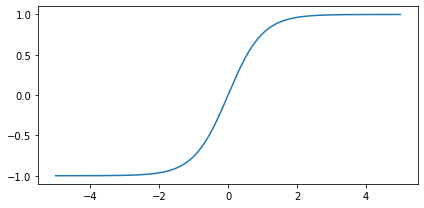

In [9]:
# the import statement for matplotlib
import matplotlib.pyplot as plt

# create a sample of points to plot over 
w_vals = np.linspace(-5,5,200)

# evaluate the function over each of these values - one can use an explicit for-loop here instead of a list comprehension
g_vals = [g(v) for v in w_vals]

# plot
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(w_vals,g_vals)
plt.show()

Now, using ``autograd`` we can then compute the derivative of our function here automatically.  Below we show the proper import statement and manner of using the gradient calculator - called ``grad``.

In [10]:
# import statment for gradient calculator
from autograd import grad    

To use ``grad`` we simply pass in the function we wish to differentiate.  ``grad`` works by *explicitly* computing the computation graph of our input, giving us a ``Python`` function for its derivative that we can then evaluate wherever we want.  It does not provide an *algebraic function*, but a *`Python` function*.  Here we call the derivative function of our input ``dgdw``.

In [11]:
# create the derivative/gradient function of g --> called dgdw
dgdw = grad(g)

The gradient function can be evaluated like our original ``Python`` function - as shown below.  

In [12]:
# evaluate the gradient function at a point
w_val = 1.0
print (dgdw(1.0))

0.4199743416140261


Just as with our original ``Python`` function we can then evaluate our gradient ``dgdw`` over a fine range of input and plot the result.  We do this below, plotting the original function as well for comparison.  

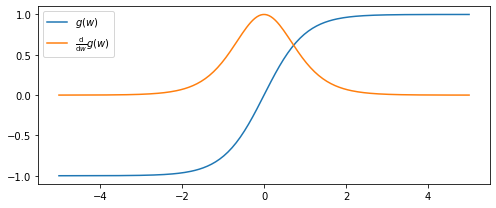

In [13]:
# create space over which to evaluate function and gradient
w_vals = np.linspace(-5,5,200)

# evaluate gradient over input range
g_vals = [g(v) for v in w_vals]
dg_vals = [dgdw(v) for v in w_vals]

# create figure
fig = plt.figure(figsize = (7,3))

# plot function and gradient values
plt.plot(w_vals,g_vals)
plt.plot(w_vals,dg_vals)
plt.legend([r'$g(w)$',r'$\frac{\mathrm{d}}{\mathrm{d}w}g(w)$']) 
plt.show()

We can compute higher order derivatives of our input function by using the same ``autograd``  functionality recursively, i.e., by plugging in the derivative ```dgdw``` into ``autograd``'s ``grad`` function.  Doing this once gives us the second derivative `Python` function - which we call `dgdw2` - as shown below.

In [14]:
# compute the second derivative of our input function
dgdw2 = grad(dgdw)

We can then plot the input function, as well as the first and second derivatives, as shown below.

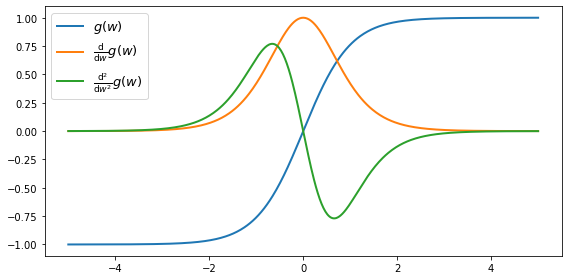

In [15]:
# define set of points over which to plot function and first two derivatives
w = np.linspace(-5,5,500)

# evaluate the input function g, first derivative dgdw, and second derivative dgdw2 over the input points
g_vals = [g(v) for v in w]
dg_vals = [dgdw(v) for v in w]
dg2_vals = [dgdw2(v) for v in w]

# plot the function and derivative
fig = plt.figure(figsize = (8,4))
plt.plot(w,g_vals,linewidth=2)
plt.plot(w,dg_vals,linewidth=2)
plt.plot(w,dg2_vals,linewidth=2)
plt.legend(['$g(w)$',r'$\frac{\mathrm{d}}{\mathrm{d}w}g(w)$',r'$\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)$'],fontsize = 13)
plt.show()

#### <span style="color:#a50e3e;">Example 2. </span> Remember, whenever you use an Automatic Differentiatior to evaluate a gradient you are explicitly evaluating the function as well

Above you may notice that the derivative function ``dgdw`` we have constructed returns only the derivative evaluation, and not the function evaluation itself (we have computed this separately when e.g., plotting a range of function / derivative values above).  However as we described in the previous Sections, an Automatic Differentiator will always need to compute the value of the function itself whenever we use it to compute a derivative / gradient evaluation.  *So - in other words - whenever we evaluate the gradient, we get the function evaluation for free*.  This is a very handy technical fact which will save us a ton of computation later on when we discuss e.g., supervised learning models.  

We can already see an example of the waste - e.g., in the previous example when we evaluated / plotted the function and its first derivative there was no need to actually evaluate the function explicitly since these computations are already performed when we evaluate the gradient.  However when we used ``autograd``'s ``grad`` functionality to compute the gradient of our function in the previous example, and then evaluated it at a single point, ``grad`` only returned a single value: the evaluation of the derivative.  No function evaluation was returned - so where is the mirror function evaluation?  Well the function evaluation is indeed being computed 'under the hood' of ``grad``, it is simply not being returned via this method.  This is a design choice made by the authors of ``autograd`` to keep the interface of ``grad`` - their introductary Automatic Differentiation method - easy to pick up and use for a wide audience.  Later when the need to re-compute function evaluations becomes quite costly we will use this ``autograd`` method exclusively (one can view the entire list of ``autograd`` [methods available here](https://github.com/HIPS/autograd/blob/master/autograd/differential_operators.py). 

Now there is another ``autograd`` method called ``value_and_grad`` that returns everything computed 'under the hood' -  both the derivative(s) and function evaluations.  Below we use this ``autograd`` functionality to re-produce the previous example first derivative calculations.

In [16]:
# import statement for gradient calculator - this method will return both
# derivative and function evaluations (the latter always being computed 'under
# the hood')
from autograd import value_and_grad 

# how to use 'lambda' to create an "anonymous" function - just a pithier way of writing functions in Python
g = lambda w: np.tanh(w)

# create the derivative/gradient function of g --> called dgdw
dgdw = value_and_grad(g)

We have our derivative function ``dgdw`` above computed now using ``value_and_grad``.  Below we plug in a single point into this derivative function, and what is returned is both the function (left value) and derivative (right value) evaluation.  This function evaluation comes 'for free' whenever we evaluate the derivative - we need not evaluate the function itself again.

In [17]:
# evaluate the gradient function at a point
w_val = 1.0
print (dgdw(1.0))

(0.7615941559557649, 0.4199743416140261)


Now we use this to plot both the function and derivative over the same range used in the previous example - again without re-computing the function evaluations.

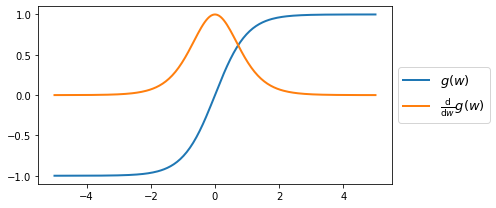

In [18]:
# create space over which to evaluate function and gradient
w_vals = np.linspace(-5,5,200)

# evaluate gradient over input range
g_vals = [dgdw(v)[0] for v in w_vals]
dg_vals = [dgdw(v)[1] for v in w_vals]

# create figure
fig = plt.figure(figsize = (7,3))

# plot the function and derivative
plt.plot(w_vals,g_vals,linewidth=2)
plt.plot(w_vals,dg_vals,linewidth=2)
plt.legend(['$g(w)$',r'$\frac{\mathrm{d}}{\mathrm{d}w}g(w)$',r'$\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)$'],loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 13)
plt.show()

#### <span style="color:#a50e3e;">Example 3. </span> Computing Taylor series approximations

Using ``autograd`` we can quickly illustrate Taylor series approximations (see the Appendix for definition) of any single-input function.  Below we illustrate the ``tanh`` function, along with a first order Taylor series approximation 

\begin{equation}
h(w) = g(w^0) + \frac{\mathrm{d}}{\mathrm{d}w}g(w^0)(w - w^0)
\end{equation}

centered at the point $w^0 = 1$.  First we produce this function and its first order Taylor series approximation in `Python` below.

In [19]:
# create function / first derivative
g = lambda w: np.tanh(w) 
dgdw = grad(g)

# create first order taylor series approximation - as a Python function
# here w_0 is the center point of the expansion
first_order = lambda w_0,w: g(w_0) + dgdw(w_0)*(w - w_0)

Now we evaluate and plot the function and its first order approximation.  The function is shown in black, its first order approximation centered at $w_0 = 1$ is shown in green, and the point of tangency with the function shown as a red point.

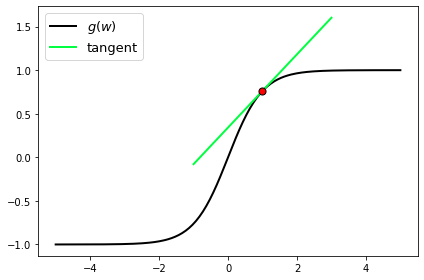

In [20]:
# create area over which to evaluate everything
w = np.linspace(-5,5,200); w_0 = 1.0; w_=np.linspace(-2+w_0,2+w_0,200);

# define and evaluate the function, define derivative
gvals = [g(v) for v in w]

# create tangent line at a point w_0
tangent = first_order(w_0,w_)

# plot the function and derivative 
fig = plt.figure(figsize = (6,4))
plt.plot(w,gvals,c = 'k',linewidth=2,zorder = 1)
plt.plot(w_,tangent,c = [0,1,0.25],linewidth=2,zorder = 2)
plt.scatter(w_0,g(w_0),c = 'r',s=50,zorder = 3,edgecolor='k',linewidth=1)
plt.legend(['$g(w)$','tangent'],fontsize = 13)
plt.show()

Its just as easy to show the second order Taylor series approximation as well, whose formula is given as

\begin{equation}
h(w) = g(w^0) + \frac{\mathrm{d}}{\mathrm{d}w}g(w^0)(w - w^0) +  \frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0)(w - w^0)^2.
\end{equation}

Below we compute and plot both the ``tanh`` function, along with its first and second order Taylor series approximations at the point $w^0 = 1$.  

In [21]:
# create second derivative function
dgdw2 = grad(dgdw)
    
# create second order taylor series approximation - as a Python function
# here w_0 is the center point of the expansion
second_order = lambda w_0,w: g(w_0) + dgdw(w_0)*(w - w_0) + 0.5*dgdw2(w_0)*(w - w_0)**2

The first and second order approximations are shown below in green and blue respectively, with the point of expansion again shown as a red point.

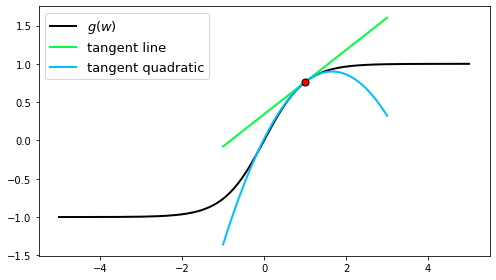

In [22]:
# create area over which to evaluate everything
w = np.linspace(-5,5,200); w_0 = 1.0; w_=np.linspace(-2+w_0,2+w_0,200);

# define and evaluate the function, define derivative
gvals = [g(v) for v in w]

# create tangent line and quadratic
tangent = first_order(w_0,w_)
quadratic = second_order(w_0,w_)

# plot the function and derivative 
fig = plt.figure(figsize = (7,4))
plt.plot(w,gvals,c = 'k',linewidth=2,zorder = 1)
plt.plot(w_,tangent,c = [0,1,0.25],linewidth=2,zorder = 2)
plt.plot(w_,quadratic,c = [0,0.75,1],linewidth=2,zorder = 2)
plt.scatter(w_0,g(w_0),c = 'r',s=50,zorder = 3,edgecolor='k',linewidth=1)
plt.legend(['$g(w)$','tangent line','tangent quadratic'],fontsize = 13)
plt.show()

#### <span style="color:#a50e3e;">Example 4. </span> Computing individual partial derivatives of a multi-input functions using ``autograd``

There are a number of ways we can go about using `autograd` to compute the partial derivatives of a multi-input function.  First lets look at how to use `autograd` to compute partial derivatives individually, or one-at-a-time.

As an example lets look at the following function

\begin{equation}
g\left(w_1,w_2\right) = \text{tanh}\left(w_1w_2\right).
\end{equation}

This simple function takes in two inputs - $w_1$ and $w_2$ - and here we have written them out *explicitly*.  Below we translate this function into `Python` - note here we use the longer form ``def`` version of a ``Python`` function, but we could of course use the pithier ``lambda`` version if we like.

In [23]:
# a simple multi-input function defined in python 
def g(w_1,w_2):
    return np.tanh(w_1*w_2)

Taking in two inputs, this function lives in three dimensions.  Below we plot it over a small range of its input.

<ipython-input-24-356e013a93db>:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax1 = fig.gca(projection='3d')


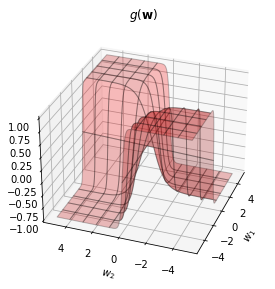

In [24]:
# import three-dimensional plotting library into namespace
from mpl_toolkits.mplot3d import Axes3D

### evaluate our function over a fine range of points on a square
# produce grid of values
s = np.linspace(-5,5,500)
w1,w2 = np.meshgrid(s,s)

# reshape grid and evaluate all points using our function
w_1 = np.reshape(w1,(1,np.size(w1)))
w_2 = np.reshape(w2,(1,np.size(w2)))
g_vals = g(w_1,w_2)

# generate figure and panel
fig = plt.figure(figsize = (4,4))
ax1 = fig.gca(projection='3d')

# re-shape inputs and output for plotting
# matplotlib's surface plotter requires all
# three input arguments are 2d arrays
w1 = np.reshape(w1,(np.size(s),np.size(s)))
w2 = np.reshape(w2,(np.size(s),np.size(s)))
g_vals = np.reshape(g_vals,(np.size(s),np.size(s)))

# Plot the surface
ax1.plot_surface(w1,w2,g_vals,alpha = 0.25,color = 'r',cstride = 50,rstride = 50,edgecolor = 'k')
ax1.set_title(r'$g\left(\mathbf{w}\right)$',fontsize = 12)
ax1.set_xlabel(r'$w_1$',fontsize = 10)
ax1.set_ylabel(r'$w_2$',fontsize = 10)
ax1.view_init(30,200)
plt.show()

Now we use ``autograd``'s ``grad`` function to compute the two partial derivative functions here.  In this example since our function $g$ takes in two inputs its gradient consists of two partial derivative functions each of which takes in the two inputs $w_1$ and $w_2$ as well

\begin{equation}
\nabla g\left(w_1,w_2\right) = 
\begin{bmatrix}
\frac{\partial}{\partial w_1}g\left(w_1,w_2\right) \\
\frac{\partial}{\partial w_2}g\left(w_1,w_2\right)
\end{bmatrix}.
\end{equation}

We can use the same `autograd` functionality used previously with single input functions here, with one simple addition - now we specify which partial derivative function we wish to construct.  If we use the exact same call we used e.g., in the previous example and write

                                        grad(g)

here - since our function takes in two inputs - this will return the *first* partial derivative $\frac{\partial}{\partial w_1}g\left(w_1,w_2\right)$.  This is the *default* setting of each automatic differentiation method in `autograd`.  

Alternatively to compute this partial derivative function we can explicitly pass a second argument to `grad` - or any of the other `autograd` methods - which is a simple index denoting which partial derivative we want.  To create the same (first) partial derivative this way we pass in the index `0` - since `Python` indexing starts with `0`

                                        grad(g,0)

To construct the second partial derivative we use the same `Pythonic` language, but pass the second index `1`

                                        grad(g,1)

More generally speaking, if $g$ took in $N$ inputs $w_1$ through $w_N$ we can construct its $n^{th}$ partial derivative using the same pattern as

                                        grad(g,n-1)

and so on.

Back to our example - below define both partial derivatives using these commands below.

In [25]:
# compute the gradient of our input function
dgdw1 = grad(g,0)
dgdw2 = grad(g,1)

These two partial derivative functions can now be used precisely as the original function $g$ in `Python`, which we do to produce plots of each as shown below. 

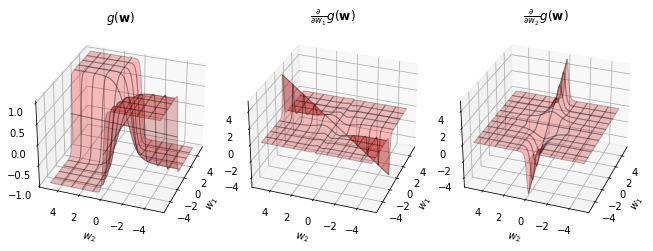

In [26]:
# load in the gridspec tool from matplotlib for better subplot handling
from matplotlib import gridspec

# produce grid of values to plot over
s = np.linspace(-5,5,500)
w1,w2 = np.meshgrid(s,s)

# reshape grid and evaluate all points using our function
w1 = np.reshape(w1,(1,np.size(w1)))
w2 = np.reshape(w2,(1,np.size(w2)))

# evaluate original function and partial derivatives
g_vals = g(w1,w2)
partial_1vals = np.array([dgdw1(a[0],b[0]) for a,b in zip(w1.T,w2.T)])
partial_2vals = np.array([dgdw2(a[0],b[0]) for a,b in zip(w1.T,w2.T)])

# reshape each partial evaluations appropriately for plotting
w1 = np.reshape(w1,(np.size(s),np.size(s)))
w2 = np.reshape(w2,(np.size(s),np.size(s)))
g_vals = np.reshape(g_vals,(np.size(s),np.size(s)))
partial_1vals = np.reshape(partial_1vals,(np.size(s),np.size(s)))
partial_2vals = np.reshape(partial_2vals,(np.size(s),np.size(s)))

# initialize figure
fig = plt.figure(figsize = (9,4))
ax1=fig.add_subplot(131,projection='3d')
ax2=fig.add_subplot(132,projection='3d')
ax3=fig.add_subplot(133,projection='3d')

# plot surfaces
ax1.plot_surface(w1,w2,g_vals,alpha = 0.25,color = 'r',cstride = 50,rstride = 50,edgecolor = 'k')
ax1.set_title(r'$g\left(\mathbf{w}\right)$',fontsize = 12)
ax1.set_xlabel(r'$w_1$',fontsize = 10)
ax1.set_ylabel(r'$w_2$',fontsize = 10)
ax1.view_init(30,200)

ax2.plot_surface(w1,w2,partial_1vals,alpha = 0.25,color = 'r',cstride = 50,rstride = 50,edgecolor = 'k')
ax2.set_title(r'$\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right)$',fontsize = 12)
ax2.set_xlabel(r'$w_1$',fontsize = 10)
ax2.set_ylabel(r'$w_2$',fontsize = 10)
ax2.view_init(30,200)

ax3.plot_surface(w1,w2,partial_2vals,alpha = 0.25,color = 'r',cstride = 50,rstride = 50,edgecolor = 'k') 
ax3.set_title(r'$\frac{\partial}{\partial w_2}g\left(\mathbf{w}\right)$',fontsize = 12)
ax3.set_xlabel(r'$w_1$',fontsize = 10)
ax3.set_ylabel(r'$w_2$',fontsize = 10)
ax3.view_init(30,200)
plt.show()

#### <span style="color:#a50e3e;">Example 5. </span> Computing several derivatives or the full gradient of a multi-input functions using ``autograd``

Building on the previous example, here we look at how to use `autograd` to construct several partial derivative functions or the entire gradient of a multi-input function.  We do this via example, using the same of function employed in the previous example.

There are two ways to construct multiple partial derivative functions at once - including the full gradient - using `autograd`.  The first way is to simply index all the partial derivatives desired using the same sort of notation introduced previously.  So here - for example - if we wish to construct the full gradient of our function (it has two partial derivatives) we tell `autograd` of this desire by feeding in the two indices $(0,1)$ as shown below

                                        grad(g,(0,1))

More generally, for a function taking in $N$ inputs, to construct any subset of partial derivatives at once we use the same sort of indexing notation.  Note: this usage applies to all methods in the `autograd` automatic differentiation library (like e.g., `value_and_grad`).

We do this below for the function shown in the previous example, producing a function for its complete gradient.

In [ ]:
# construct all partial derivative functions at once
nabla_g = grad(g,(0,1))

The second way to construct several derivatives at once using `autograd` is by writing a function in `numpy` where all the desired variables we wish to differentiate with respect to are all input into the function as a *single argument*.  For example, if instead of writing out our function in `Python` as

In [27]:
# a simple multi-input function defined in python 
def g(w_1,w_2):
    return np.tanh(w_1*w_2)

where both $w_1$ and $w_2$ are fed in one-at-a-time, if we write it equivalently using vector-notation where $\mathbf{w} = \begin{bmatrix}w_1 \\ w_2 \end{bmatrix}$ as

In [29]:
def g(w):
    return np.tanh(w[0]*w[1])

then the call

                                        grad(g)

or equivalently

                                        grad(g,0)

will produce derivatives of $g$ with respect to its *first argument* - which here will give us the complete gradient of $g$.  Before that first argument was just $w_1$, but now in our new way of writing the function it is the complete set of inputs $\mathbf{w}$ (i.e., all partial derivatives of the function).

This indexing format holds more generally as well - if in the way we express a function in `numpy` it takes in $N$ inputs, the statement

                                        grad(g,n-1)

computes the derivatives of the function with respect to whatever the $n^{th}$ input is - i.e., whether it is a single variable or multiple variables.

As another example, take the inner product function of two length $M$ vectors $\mathbf{a}$ and $\mathbf{b}$

\begin{equation}
g\left(\mathbf{a},\mathbf{b}\right) = \mathbf{a}^T\mathbf{b}
\end{equation}

Writing 

                                        grad(g)

or 

                                        grad(g,0)

gives us the partial derivative functions for all entries of $\mathbf{a}$.  Likewise

                                        grad(g,1)

gives us the partial derivative functions for all entries of $\mathbf{b}$.

## Automatic Differentiation versus Numerical and Symoblic Differentiation

Automatic Differentiators are gradient calculators that compute and provide a *compute program-based* function for evaluating the derivative(s) of a function.  There are however other kinds of gradient calculators - including *Numerical Differentators* and *Symbolic Differentiators*.  The former are built using the fundamental *limit definition* of the derivative (not the derivative rules themselves).  While simple to implement they have stability issues that make them less useful as a universal gradient calculator (this is discussed in further detail in the text's appendix).  Symbolic Differentiators - which computes an algebraic formula for derivatives instead of a compute program function - are far less useful for our applications since we primarily need *programmatic gradient functions* (for use in local optimization schemes).  In addition, algebraic derivative equations can quickly become unweildly and require large amounts of memory to represent (particularly with multi-input functions, which we deal with extensively in machine learning).  

##  Flattening mathematical functions using `autograd`

Mathematical functions come in all shapes and sizes and - moreover - we can often express indnividual equations in a variety of different ways.  This short section discusses a standardization technique called *function flattening*, which allows us to express any mathematical function  in the generic form $g\left(\mathbf{w}\right)$ we have been using thus far.  Flattening is a particularly useful *pre-processing* step as it allows us to more broadly understand the fundamental optimization precepts we have / will see as well as more easily *implement* (in code) local optimization steps of the generic form

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} + \alpha \, \mathbf{d}^{k}.
\end{equation}

Take the following quadratic function $f$ of two $N\times 1$ variables $\mathbf{a}$ and $\mathbf{b}$

\begin{equation}
f\left(\mathbf{a},\mathbf{b} \right) = \left(\sum_{n=1}^{N} a_nb_n\right)^2.
\end{equation}

This function is not written in the generic form $g\left(\mathbf{w}\right)$ we have used throughout this Chapter (and which we will use throughout future Chapters as well), but of course all of the principles and algorithms we have seen / will see still apply to it.  So we can e.g., apply gradient descent to minimize the function.  To do this however we need to compute the gradient of $h$ with respect to  each input variable $\mathbf{a}$ and $\mathbf{b}$, and descend in each input variable as

\begin{equation}
\begin{array}
\
\mathbf{a}^k = \mathbf{a}^{k-1} - \alpha \, \nabla_{\mathbf{a}}\,f\left(\mathbf{a}^{k-1},\mathbf{b}^{k-1}\right) \\
\mathbf{b}^k = \mathbf{b}^{k-1} - \alpha \, \nabla_{\mathbf{b}}\,f\left(\mathbf{a}^{k-1},\mathbf{b}^{k-1}\right) \\
\end{array}
\end{equation}

in order to complete the $k^{th}$ step. 

There is a absolutely nothing wrong with this - it is a valid gradient descent step for the function given above.  It is however slightly more cumbersome to write - and implement - than a function of a single set of inputs like our standard $g\left(\mathbf{w}\right)$ whose descent step can be written and implemented in a single line (one taken in $\mathbf{w}$).  This annoyance is greatly amplified when dealing with functions of many inputs variables - which can be scalars, vectors, or even matrices - which we will regularly encounter during our machine learning voyage.  For such functions, in order to take a single gradient descent step we must *loop* over their many different input variables.

Thankfully every mathematical function can be re-expressed so that *all* of its input variables are represented as a single contiguous array $\mathbf{w}$, which alleivates this irritation.  For example in the example above we can easily see that by *re-indexing* entries of $\mathbf{a}$ and $\mathbf{b}$ using a single array as

\begin{equation}
\mathbf{w} = 
\begin{bmatrix}
a_1 \\
\vdots \\
a_N \\
b_1 \\
\vdots \\
b_N \\
\end{bmatrix} = 
\begin{bmatrix}
w_1 \\
\vdots \\
w_N \\
w_{N+1} \\
\vdots \\
w_{2N} \\
\end{bmatrix}
\end{equation}

the function in equation (1) above can then be equivalently written as

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{n=1}^N\left(w_nw_{n+N}\right)^2.
\end{equation}

Again note that all we have really done here is *re-indexed* the entries of both input vectors in a contiguous manner.  When expressed in this standardized manner we can both more easily reference optimization principles (which were scribed in Sections for functions in this standard form) and implement local optimization schemes like gradient descent in a less cumbersome way in a single line of algebra or `autograd` `Python` code, instead of requiring a loop over each input variable.  This variable re-indexing scheme is called *function flattening*, and can be applied to any mathematical function in principle. 

While performing the re-indexing required to flatten a function properly by hand for each and every function we come across is important, it (like derivative computation itself) is a repetitive and time consuming operations for human to perform themselves.  Therefore *in practice* we will automate this task, employing a flattening module from the `Python` `autograd` library.  This module can be imported from the `autograd` library (introduced in the previous Section) via the line below.

In [30]:
# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

#### <span style="color:#a50e3e;">Example 5. </span>  Gradient descent on a flattened function

In this example we take the following function of several variables - a scalar, vector, and matrix

\begin{equation}
f\left(a,\mathbf{b},\mathbf{C}\right) = 
\left(a + \mathbf{z}^T\mathbf{b} + 
\mathbf{z}^T\mathbf{C}\mathbf{z} 
\right)^2
\end{equation}

and flatten it using the `autograd` module `flatten_func` in order to then minimize it using the gradient descent implementation given above.  Here the input variable $a$ is a scalar, $\mathbf{b}$ is a $2 \times 1$ vector, $\mathbf{C}$ is a $2\times 2$ matrix, and the non-variable vector $\mathbf{z}$ is fixed at $\mathbf{z} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$.

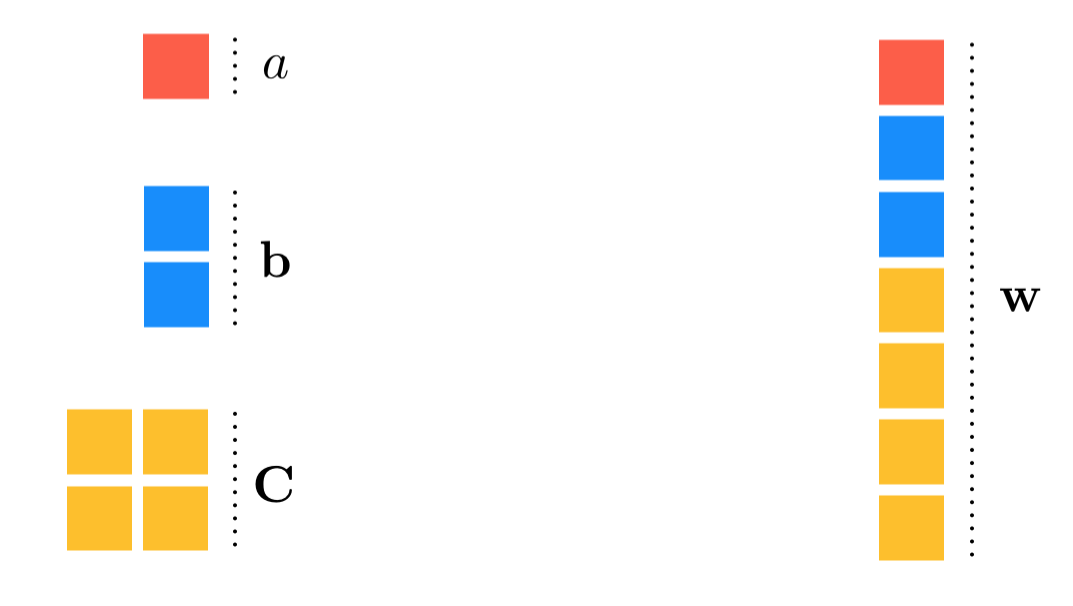

In [32]:
Image(image_path_1, width=400)

<figure>
<figcaption>   
<strong>Figure 2:</strong> <em> A figurative illustration of function flattening using the current example.
</em>  </figcaption> 
</figure>

Below we define a `Python` version of the function defined above.  Note here that the input to this implementation is a list of the functions input variables (or weights).

In [31]:
# Python implementation of the function above

z = np.ones((2,1))

def f(input_weights):
    a = input_weights[0]
    b = input_weights[1]
    C = input_weights[2]
    return (((a + np.dot(z.T,b) + np.dot(np.dot(z.T,C),z)))**2)[0][0]

To flatten a mathematical function scribed in `numpy` and `Python` called `f` - written in such a way that it takes in a single list containing all of its input variables - we then simply call the line below.  Here on the right hand side `weights` is a list of initializations for input variables to the function `f`.  The outputs `g`, `unflatten_func`, and `w` are the flattened version of `f`, a module to unflatten the input weights, and a flattened version of the intitial weights respectively.

In [33]:
N = 2 
a = np.random.randn(1,1)
b = np.random.randn(N,1)
C = np.random.randn(N,N)

input_weights = [a,b,C]

# flatten an input function g
g, unflatten_func, w = flatten_func(f, input_weights)

By using the `flatten_func` module as shown above we can then minimize the flattened version of this function properly.  We show a cost function history from one run of gradient descent below - where $15$ steps were taken from a random initialization.  This run reaches a point very near the function's minimum at the origin.

In [34]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

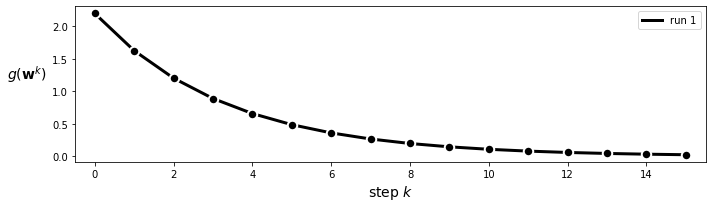

In [35]:
# run optimization
alpha = 10**(-2)
max_its = 15
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)
section_3_5_helpers.plot_cost_histories([cost_history],start = 0,points = True,labels = ['run 1','run 2'])